In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.optimize as opt
import scipy.linalg as la
import scipy.interpolate as interp
import scipy.integrate as integ
import scipy.special as sf
import matplotlib as mpl
from astropy.io import ascii
mpl.rc('xtick', direction='in', top=True)
mpl.rc('ytick', direction='in', right=True)
mpl.rc('xtick.minor', visible=True)
mpl.rc('ytick.minor', visible=True)
from scipy.stats import binned_statistic
plt.rcParams['font.size'] = 15
plt.rcParams['figure.figsize'] = [7,5]
#import Fraunhofer
%run Fraunhofer
%run ErrMask.py

In [ ]:
# define beam and gaussian functions
def b_lm(l, sigma):
  #l = screen['kap']*np.pi*2
  blm = np.exp(-l*(l+1)*sigma**2/2)
  return(blm)
def sigma_calc(r,sigma):
  gaussian = bin_mean.max()*np.exp(-r**2/(sigma**2))
  return(gaussian)


In [ ]:
# create screen [m]
screen = {}
screen['N'] = 4096
screen['D'] = 10
Initialize(screen)
center = (screen['D']/2, screen['D']/2)
MultByGaussian(screen, center, 0.5)
#InCircle(screen, center, 2.0)
ScreenFFT(screen)

N_theta=1024
# interpolation in sky intensity [rad]
lam = 0.002 #mm wavelength
thetamaxdeg = 2.0
thetamax = thetamaxdeg*np.pi/180. # 2 degrees in radians
theta_vec = np.linspace(-thetamax,thetamax,N_theta) 
II0 = Project_I_on_thetagrid(theta_vec,screen,lam) 

# #create screen [m] with error map
# screen1 = {}
# screen1['N'] = 4096
# screen1['D'] = 10
# Initialize(screen1)
# center = (screen1['D']/2, screen1['D']/2)
# MultByGaussian(screen1, center, 1.0)
# emap = filter_annulus_amp(screen1, 10.0, 10, 12)
# InCircle(screen1, center, 2.0)
# ScreenFFT(screen1)

# II1 = Project_I_on_thetagrid(theta_vec,screen1,lam) 

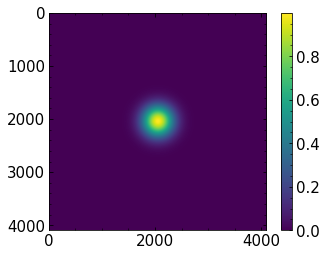

In [ ]:
fig = plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.imshow(screen['E'])
plt.colorbar()
# plt.subplot(1,2,2)
# plt.imshow(screen1['E'])
# plt.colorbar()
# plt.show()


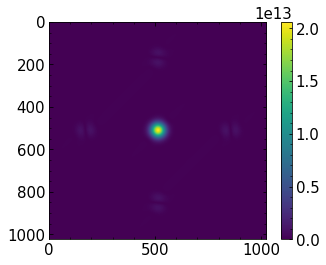

In [ ]:
# FFT the sky intensity to ell space (ifft for comparison)
fft_I0 = np.fft.fftshift(np.fft.fft2(np.fft.fftshift(II0)))   # fft of sky intensity (1/rad) 
blm_numerical0 = np.abs(fft_I0) #numerically calculated beam in [1/rad] k space
# fft_I1 = np.fft.fftshift(np.fft.fft2(np.fft.fftshift(II1)))   # fft of sky intensity (1/rad) with errors
# blm_numerical1 = np.abs(fft_I1)**2 #numerically calculated beam in [1/rad] k space with errors
fig = plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.imshow(np.abs(fft_I0)) # FFT of sky intensity
plt.colorbar()
# plt.subplot(1,2,2)
# plt.imshow(np.abs(fft_I1))
# plt.colorbar()
# plt.show()
# plt.imshow(np.abs(blm_numerical0 - blm_numerical1))
# #plt.xlim(462,562)
# #plt.ylim(462,562)
# plt.colorbar()


In [ ]:
# same ell vector for both unperturbed and perturbed maps
n = theta_vec.shape[0]
dl = 2*np.pi/theta_vec.ptp() # dl in 1/rad space
l_vec = dl*np.fft.fftshift(np.fft.fftfreq(n))*n
(l_x, l_y) = np.meshgrid(l_vec,l_vec) # 1/rad 
l = np.sqrt(l_x**2 + l_y**2)


# n = theta_vec.shape[0]
# kmax = n / (2*theta_vec.max())
# k_vec = np.linspace(-kmax, kmax, n)
# (k_x, k_y) = np.meshgrid(k_vec,k_vec) # 1/rad 
# k_r = np.sqrt(k_x**2 + k_y**2)
# l = k_r * 2 * np.pi

def b_lm(l, sigma):
  #l = screen['kap']*np.pi*2
  blm = np.exp(-l*(l+1)*sigma**2/2)
  return(blm)
def sigma_calc(r,sigma):
  gaussian = bin_mean.max()*np.exp(-r**2/(2*sigma**2))
  return(gaussian)


Fitted beam sigma in sky is 0.0242 deg


(0.0, 0.1)

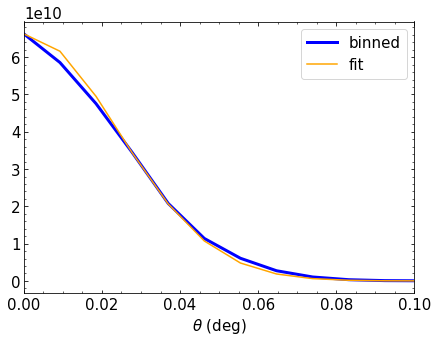

In [ ]:
# fit sigma in sky (rad) for the perfect beam only. 
(thetax, thetay) = np.meshgrid(theta_vec, theta_vec) # rad 
theta_r = np.sqrt(thetax**2 + thetay**2)
bin_edges = np.linspace(0,theta_r.max(),int(0.3*N_theta)) # bin radially
theta_flatten = theta_r.flatten()
I_flatten = II0.flatten()
bin_mean, bin_edge, bin_num = binned_statistic(theta_flatten, I_flatten, statistic='mean', bins=bin_edges) # calculate binned sky intensity
(fit, err) = opt.curve_fit(sigma_calc, bin_edges[0:-1], bin_mean, p0=1e-4, absolute_sigma=True) # fit the binned intensity for the beam width sigma
print('Fitted beam sigma in sky is {:.4f} deg'.format(fit[0]*180/np.pi))

fig = plt.figure(figsize=(7,5))
plt.plot(bin_edges[0:-1]*180/np.pi,bin_mean, lw=3, color='blue',label='binned')
plt.xlabel(r'$\theta$ (deg)')
plt.plot(bin_edges*180/np.pi, sigma_calc(bin_edges, fit[0]), lw=1.5, color='orange',label='fit')
plt.legend()
plt.xlim(0,0.1)


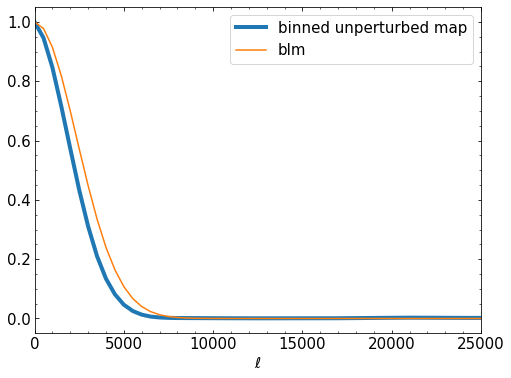

In [ ]:
 # average (FT of II0)^2 radially for the unperturbed map
bin_edges = np.arange(0,l.max(),500)
l_flatten = l.flatten()
beam_numerical0_flatten = blm_numerical0.flatten()
bin_mean0, bin_edge, bin_num = binned_statistic(l_flatten, beam_numerical0_flatten, statistic='mean', bins=bin_edges) 
l_vec = bin_edges[0:-1] # ell 1D vector

# # average (FT of II1)^2 radially for the perturbed map
# beam_numerical1_flatten = blm_numerical1.flatten()
# bin_mean1, bin_edge, bin_num = binned_statistic(l_flatten, beam_numerical1_flatten, statistic='mean', bins=bin_edges)

# plot the numerical beam and analytical beam
fig = plt.figure(figsize=(8,6))
plt.plot(l_vec,bin_mean0/bin_mean0.max(),lw=4,label='binned unperturbed map') # normalize the numerical solution
#plt.plot(l_vec,bin_mean1/bin_mean1.max(),label='binned perturbed map') # normalize the numerical solution
plt.xlabel(r'$\ell$')
blm = b_lm(l_vec, fit[0]) # analytical solution
plt.plot(l_vec, blm,label='blm') # plot the analytical solution
plt.xlim(0,25000)
#plt.ylim(0.985,1)
plt.legend()
plt.show()



(305.0, 705.0)

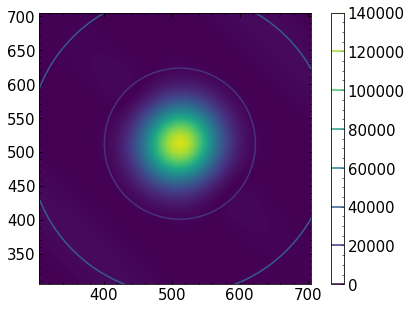

In [ ]:
plt.imshow(np.abs(fft_I1))
plt.contour(l)
plt.colorbar()
plt.xlim(305,705)
plt.ylim(305,705)

# 01/15 test blm

In [ ]:
# test gaussian 
def b_lm(l, sigma):
  #l = screen['kap']*np.pi*2
  blm = np.exp(-l*(l+1)*sigma**2/2)
  return(blm)
def sigma_calc(r,sigma):
  gaussian = bin_mean.max()*np.exp(-r**2/(2*sigma**2))
  return(gaussian)


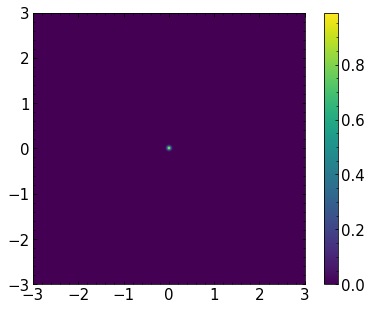

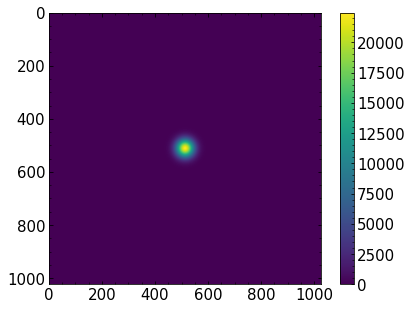

In [ ]:
# generate gaussian in sky space (theta)
n = 1024
sigma = 0.0005 # radians
sky = np.ones((n,n))
theta_max = 3 * np.pi/180 # degrees to radians
theta = np.linspace(-theta_max,theta_max,n)
theta_x, theta_y = np.meshgrid(theta,theta)
theta_r = np.sqrt(theta_x**2+theta_y**2)
sky = sky * np.exp(-theta_r**2/(2*sigma**2))
fft_sky = np.abs(np.fft.fftshift(np.fft.fft2(np.fft.fftshift(sky))))**2

plt.imshow(sky, extent=[-3,3,-3,3])
plt.colorbar()
plt.show()
plt.imshow(fft_sky)
plt.colorbar()
plt.show()

In [ ]:
#dk = 1/theta_max # dk in 1/rad space
#k_vec = dk*np.fft.fftshift(np.fft.fftfreq(n))*n
kmax = n / (2*theta_max)
k_vec = np.linspace(-kmax, kmax, n)
(k_x, k_y) = np.meshgrid(k_vec,k_vec) # 1/rad 
k_r = np.sqrt(k_x**2 + k_y**2)
l = k_r * 2 * np.pi


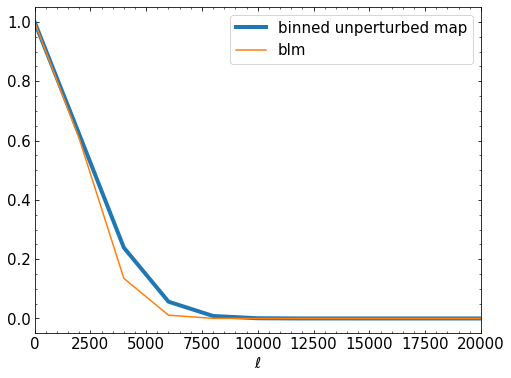

In [ ]:
# average (FT of II0)^2 radially for the unperturbed map
bin_edges = np.arange(0,l.max(),2000)
l_flatten = l.flatten()
beam_numerical0_flatten = fft_sky.flatten()
bin_mean0, bin_edge, bin_num = binned_statistic(l_flatten, beam_numerical0_flatten, statistic='mean', bins=bin_edges) 
l_vec = bin_edges[0:-1] # ell 1D vector
# bin_edges = np.arange(0,k_r.max(),1000)
# k_flatten = k_r.flatten()
# beam_numerical0_flatten = fft_sky.flatten()
# bin_mean0, bin_edge, bin_num = binned_statistic(k_flatten, beam_numerical0_flatten, statistic='mean', bins=bin_edges) 
# kk_vec = bin_edges[0:-1] # ell 1D vector


# plot the numerical beam and analytical beam
fig = plt.figure(figsize=(8,6))
plt.plot(l_vec,bin_mean0/bin_mean0.max(),lw=4,label='binned unperturbed map') # normalize the numerical solution
plt.xlabel(r'$\ell$')
blm = b_lm(l_vec, sigma) # analytical solution
plt.plot(l_vec, blm,label='blm') # plot the analytical solution
plt.xlim(0,20000)
#plt.ylim(0.985,1)
plt.legend()
plt.show()



In [ ]:
1024/(3*np.pi/180)

19556.9594071321

# 01/22 + 01/29 Test gaussian beam (numerical & analytical solution)

In [ ]:
N = 1024
D = 10
xvec = np.linspace(0,D,N)
(x,y) = np.meshgrid(xvec,xvec)
r = np.sqrt(x**2+y**2)
E = np.ones((N,N))
dk = 2*np.pi/D
kvec = np.fft.fftshift(dk * np.fft.fftfreq(N)*N)
(kx,ky) = np.meshgrid(kvec,kvec)
kap= np.sqrt(kx**2 + ky**2)  

def Gaussian(E, x, y, center, sigma):
    # center must be a tuple, (xcenter,ycenter)
    x0 = center[0]
    y0 = center[1]
    R = np.sqrt((x-x0)**2 + (y-y0)**2)
    output=E*np.exp(-(R**2)/(2*sigma**2))
    return(output)
  
    

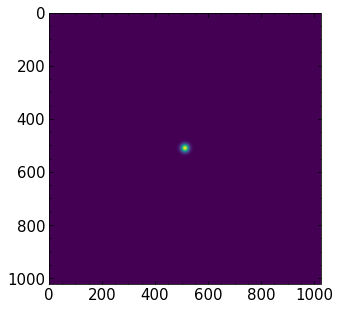

In [ ]:
center = [D/2, D/2]
sigma = 0.1
E_gaussian = Gaussian(E, x, y, center, sigma)
plt.imshow(E_gaussian)

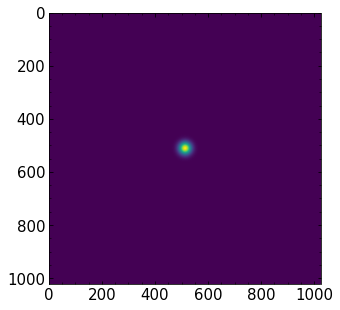

In [ ]:
E_fft = np.abs(np.fft.fftshift(np.fft.fft2(np.fft.fftshift(E_gaussian))))
plt.imshow(E_fft)

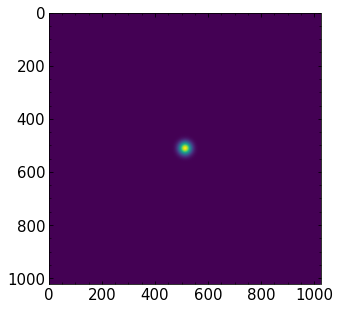

In [ ]:
test_fft = Gaussian(E, kx, ky, (0,0), 1/sigma)
plt.imshow(test_fft)

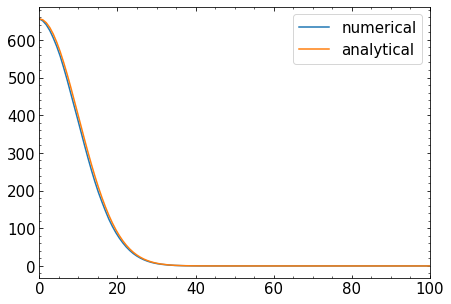

In [ ]:
# numerical
bin_edges = np.linspace(0,kap.max(),512)
k_flatten = kap.flatten()
fft_numerical = E_fft.flatten()
bin_mean0, bin_edge, bin_num = binned_statistic(k_flatten, fft_numerical, statistic='mean', bins=bin_edges) 
plt.plot(bin_edges[:-1], bin_mean0, label='numerical')

#analytical
def analytical(k, sigma):
  #k = k*np.pi*2 #!!!
  fft = bin_mean0.max()* np.exp(-k**2*sigma**2/2)
  return(fft)
plt.plot(bin_edges, analytical(bin_edges,sigma), label='analytical')
plt.xlim(0,100)
plt.legend();


01/29 test

In [ ]:
screen = {}
screen['N'] = 4096
screen['D'] = 10
Initialize(screen)
center = (screen['D']/2, screen['D']/2)
MultByGaussian(screen, center, 0.5)
ScreenFFT(screen)

N_theta=1024
lam = 0.002 #mm wavelength
thetamaxdeg = 2.0
thetamax = thetamaxdeg*np.pi/180. # 2 degrees in radians
theta_vec = np.linspace(-thetamax,thetamax,N_theta) 
II0 = Project_I_on_thetagrid(theta_vec,screen,lam) 
# shift the beam from being centered at theta=0 to theta=thetamax so that the beam spans from 0 deg to 2*thetamax deg
theta_vec = np.linspace(0,2*thetamax,N_theta) 

# FT of sky intensity
fft_I0 = np.abs(np.fft.fftshift(np.fft.fft2(np.fft.fftshift(II0)))) # in 1/rad space


In [ ]:
n = theta_vec.shape[0]
dl = 2*np.pi/theta_vec.max() # dl in 1/rad space
l_vec = np.fft.fftshift(dl * np.fft.fftfreq(n)*n)
(l_x, l_y) = np.meshgrid(l_vec,l_vec) # 1/rad 
l = np.sqrt(l_x**2 + l_y**2)


beam sigma is -0.00047 rad


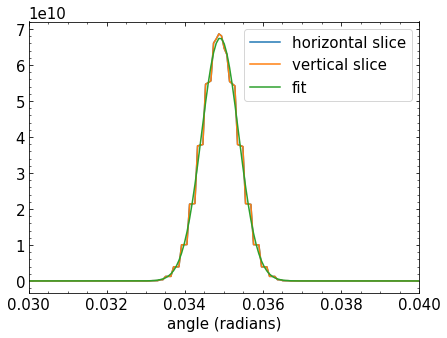

In [ ]:
# measure sigma in angle
def gaussian(x, A, sigma, x0):
  g = A*np.exp(-(x-x0)**2/(2*sigma**2))
  return(g)

plt.plot(theta_vec, II0[int(n/2)], label='horizontal slice')
plt.plot(theta_vec, II0[:,int(n/2)], label='vertical slice')
#fit 1D
(fit, err) = opt.curve_fit(gaussian, theta_vec, II0[int(n/2)], p0=np.array([II0[int(n/2)].max(), 0.01, 0.035]), absolute_sigma=True)
plt.plot(theta_vec, gaussian(theta_vec, fit[0], fit[1], fit[2]),label='fit')
plt.xlabel('angle (radians)')
plt.xlim(0.03, 0.04)
plt.legend();
print('beam sigma is {:.5f} rad'.format(fit[1]))

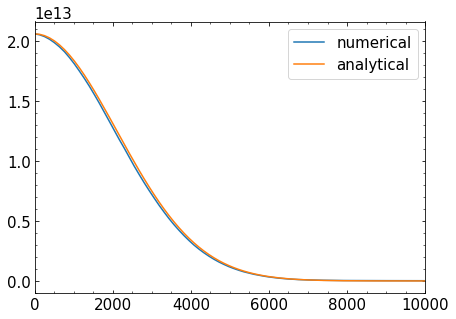

In [ ]:
# numerical
bin_edges = np.linspace(0,l.max(),512)
l_flatten = l.flatten()
fft_numerical = fft_I0.flatten()
bin_mean0, bin_edge, bin_num = binned_statistic(l_flatten, fft_numerical, statistic='mean', bins=bin_edges) 
plt.plot(bin_edges[:-1], bin_mean0, label='numerical')

#analytical
def analytical(l, sigma):
  fft = bin_mean0.max()* np.exp(-l*(l+1)*sigma**2/2)
  return(fft)
plt.plot(bin_edges, analytical(bin_edges, fit[1]), label='analytical')
plt.xlim(0,10000)
plt.legend();


# 01/30 

In [ ]:
# measure sigma in angle
def gaussian(x, A, sigma, x0):
  g = A*np.exp(-(x-x0)**2/(2*sigma**2))
  return(g)

def analytical(l, sigma):
  fft = bin_mean0.max()* np.exp(-l*(l+1)*sigma**2/2)
  return(fft)

In [ ]:
screen = {}
screen['N'] = 4196
screen['D'] = 15
Initialize(screen)
center = (screen['D']/2, screen['D']/2)
MultByGaussian(screen, center, 0.4)
ScreenFFT(screen)

N_theta=1024
lam = 0.002 #mm wavelength
thetamaxdeg = 3.0
thetamax = thetamaxdeg*np.pi/180. # 2 degrees in radians
theta_vec = np.linspace(-thetamax,thetamax,N_theta) 
II0 = Project_I_on_thetagrid(theta_vec,screen,lam) 
# shift the beam from being centered at theta=0 to theta=thetamax so that the beam spans from 0 deg to 2*thetamax deg
theta_vec = np.linspace(0,2*thetamax,N_theta) 

# FT of sky intensity
fft_I0 = np.abs(np.fft.fftshift(np.fft.fft2(np.fft.fftshift(II0)))) # in 1/rad space

#calculate ell
n = theta_vec.shape[0]
dl = 2*np.pi/theta_vec.max() # dl in 1/rad space
l_vec = np.fft.fftshift(dl * np.fft.fftfreq(n)*n)
(l_x, l_y) = np.meshgrid(l_vec,l_vec) # 1/rad 
l = np.sqrt(l_x**2 + l_y**2)

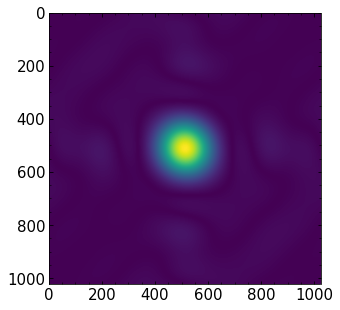

In [ ]:
plt.imshow(fft_I0)

beam sigma is 0.00057 rad


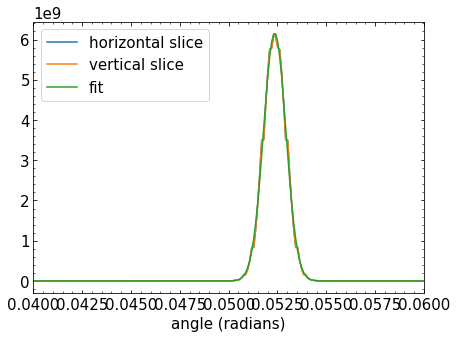

In [ ]:
plt.plot(theta_vec, II0[int(n/2)], label='horizontal slice')
plt.plot(theta_vec, II0[:,int(n/2)], label='vertical slice')

# bin radially
bin_edges = np.arange(0,l.max(),2000)
l_flatten = l.flatten()
beam_numerical0_flatten = fft_I0.flatten()
bin_mean0, bin_edge, bin_num = binned_statistic(l_flatten, beam_numerical0_flatten, statistic='mean', bins=bin_edges) 

#fit 1D
(fit, err) = opt.curve_fit(gaussian, theta_vec, II0[int(n/2)], p0=np.array([II0[int(n/2)].max(), 0.01, 0.05]), absolute_sigma=True)
plt.plot(theta_vec, gaussian(theta_vec, fit[0], fit[1], fit[2]),label='fit')
plt.xlabel('angle (radians)')
plt.xlim(0.04, 0.06)
plt.legend();
print('beam sigma is {:.5f} rad'.format(fit[1]))

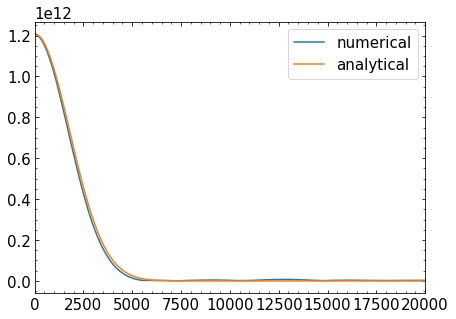

In [ ]:
# numerical
bin_edges = np.linspace(0,l.max(),512)
l_flatten = l.flatten()
fft_numerical = fft_I0.flatten()
bin_mean0, bin_edge, bin_num = binned_statistic(l_flatten, fft_numerical, statistic='mean', bins=bin_edges) 
plt.plot(bin_edges[:-1], bin_mean0, label='numerical')

plt.plot(bin_edges, analytical(bin_edges, fit[1]), label='analytical')
plt.xlim(0,20000)
plt.legend();


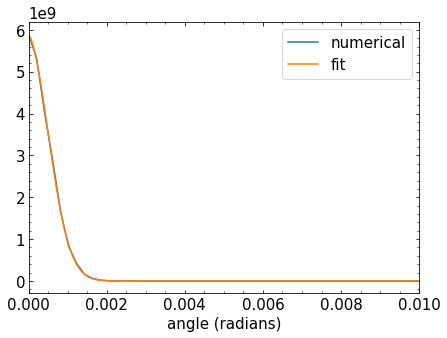

In [ ]:
# bin sky intensity and fit 
(thetax, thetay) = np.meshgrid(theta_vec, theta_vec) # rad 
theta_r = np.sqrt((thetax-thetax.max()/2)**2 + (thetay-thetay.max()/2)**2)
bins = np.linspace(0,theta_vec.max(),512)
theta_flatten = theta_r.flatten()
I_flatten = II0.flatten()
bin_mean0, bin_edge, bin_num = binned_statistic(theta_flatten, I_flatten, statistic='mean', bins=bins) 
plt.plot(bins[:-1], bin_mean0, label='numerical')
plt.xlim(0,0.01)

# fit
(fit, err) = opt.curve_fit(gaussian, bins[:-150], bin_mean0[:-149], p0=np.array([II0[int(n/2)].max(), 0.01, 0.0]), absolute_sigma=True)
plt.plot(theta_vec, gaussian(theta_vec, fit[0], fit[1], fit[2]),label='fit')
plt.xlabel('angle (radians)')
#plt.xlim(0.04, 0.06)
plt.legend();

In [ ]:
print(fit[2])

-6.697056756773091e-05
